# Lennard-Jones Potentials for modelling phase transitions in materials

Nested Sampling is the ideal tool for computing the partition function.

$$Z(\beta) = \int_\mathcal{X} e^{-\beta E(x)} \, \mathrm{d}x$$

where $\beta \in [0, \infty)$ is the inverse temperature parameter, $\mathcal{X}$ is the set of all configurations of the system, and $E : \mathcal{X} \to \mathbb{R}$ is the potential function, which in this case will be the Lennard-Jones potential,

$$E(x) = 4 \epsilon \sum_{i,j} \left( \left(\frac{\sigma}{r_{ij}}\right)^{12} - \left(\frac{\sigma}{r_{ij}}\right)^6 \right).$$

In this equation, the $-\epsilon$ represents the energy of the ground state, and $\sigma$ is the equilibrium distance when the potential energy is zero.

The system is invariant to changes in sigma and the total size of the region. Therefore, we choose $\sigma$ as a ratio with the size of the box. We'll chose to sample states within a unit box, therefore, we are choosing how big the box is in units of $\sigma$. Choosing $\sigma=0.01$ is equivalent to choosing, means the volume is roughly 100 particles per side.

In [1]:


from jax.config import config

config.update("jax_enable_x64", True)

import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp
from jax import vmap

from jaxns import Model
from jaxns import Prior
from jaxns import TerminationCondition

tfpd = tfp.distributions


INFO[2023-07-12 00:42:15,559]: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO[2023-07-12 00:42:15,559]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-07-12 00:42:15,560]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-07-12 00:42:15,561]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
INFO[2023-07-12 00:42:15,561]: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
WARNING[2023-07-12 00:42:15,562]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:

def pairwise_distances_squared(points):
    n = points.shape[0]
    pair_indices = jnp.triu_indices(n, 1)  # Upper triangular indices, excluding diagonal

    # Create function that calculates the distance between two points
    def dist_fn(ij):
        i, j = ij
        return jnp.sum(jnp.square(points[i] - points[j]))

    # Apply this function to each pair of indices
    pairwise_distances = vmap(dist_fn)(pair_indices)

    return pairwise_distances


def test_pairwise_distances_squared():
    # Example usage
    points = jnp.array([[1, 2], [3, 4], [5, 6], [7, 8]])
    assert jnp.all(pairwise_distances_squared(points) == jnp.asarray([8, 32, 72, 8, 32, 8]))

In [3]:


from jaxns.internals.log_semiring import LogSpace

num_particles = 7
sigma = jnp.asarray(0.439)
box_length = jnp.asarray(4.)


def log_likelihood(x):
    """
    V12-6 potential for LJ.
    """

    r2 = LogSpace(jnp.log(pairwise_distances_squared(x / sigma)))
    r6 = r2 * r2 * r2
    r12 = r6 * r6
    negE = r12 ** (-1) - r6 ** (-1)

    return negE.sum().value


def prior_model():
    x = yield Prior(tfpd.Uniform(low=jnp.zeros((num_particles, 3)), high=box_length * jnp.ones((num_particles, 3))),
                    name='x')
    return x


model = Model(prior_model=prior_model,
              log_likelihood=log_likelihood)

model.sanity_check(random.PRNGKey(42), 1000)


INFO[2023-07-12 00:42:16,470]: Sanity check...
INFO[2023-07-12 00:42:17,000]: Sanity check passed


In [4]:
from jaxns.samplers import UniDimSliceSampler
from jaxns.nested_sampler import StandardStaticNestedSampler

# Create the nested sampler class. In this case without any tuning.
ns = StandardStaticNestedSampler(
    model=model,
    num_live_points=100,  #model.U_ndims * 200,
    max_samples=1e6,
    sampler=UniDimSliceSampler(model=model, num_slices=model.U_ndims * 1, num_phantom_save=0, midpoint_shrink=True,
                               perfect=True)
    
)

termination_reason, state = ns(
    key=random.PRNGKey(42),
    term_cond=TerminationCondition(live_evidence_frac=1e-5)
)
results = ns.to_results(
    state,
    termination_reason
)


2023-07-12 00:42:20.094426: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  reduce-window.8 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime.  XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2023-07-12 00:42:20.466139: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 1.371776533s
Constant folding an instruction is taking > 1s:

  reduce-window.8 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).



In [5]:
# We can use the summary utility to display results
ns.summary(results)

--------
Termination Conditions:
Small remaining evidence
All live-points are on a single plateau (potential numerical errors, consider 64-bit)
--------
# likelihood evals: 8563428
# samples: 11600
# slices: 241500.0
# slices / acceptance: 21.0
# likelihood evals / sample: 738.2
# likelihood evals / slice: 35.5
--------
logZ=4.8420952640628936e+194 +- 1.5e-08
H=inf
ESS=1
--------
x[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
x[0]: 1.3 +- 0.0 | 1.3 / 1.3 / 1.3 | 1.3 | 1.3
x[1]: 3.932675183887623 +- 4.4e-16 | 3.9326751838876226 / 3.9326751838876226 / 3.9326751838876226 | 3.9326751838876226 | 3.9326751838876226
x[2]: 1.9090144841894992 +- 4.4e-16 | 1.9090144841894987 / 1.9090144841894987 / 1.9090144841894987 | 1.9090144841894987 | 1.9090144841894987
x[3]: 3.0 +- 0.0 | 3.0 / 3.0 / 3.0 | 3.0 | 3.0
x[4]: 3.5 +- 0.0 | 3.5 / 3.5 / 3.5 | 3.5 | 3.5
x[5]: 1.7 +- 0.0 | 1.7 / 1.7 / 1.7 | 1.7 | 1.7
x[6]: 3.0 +- 0.0 | 3.0 / 3.0 / 3.0 | 3.0 | 3.0
x[7]: 3.5 +- 0.0 | 3.5 / 3

WARNING[2023-07-12 00:43:56,574]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


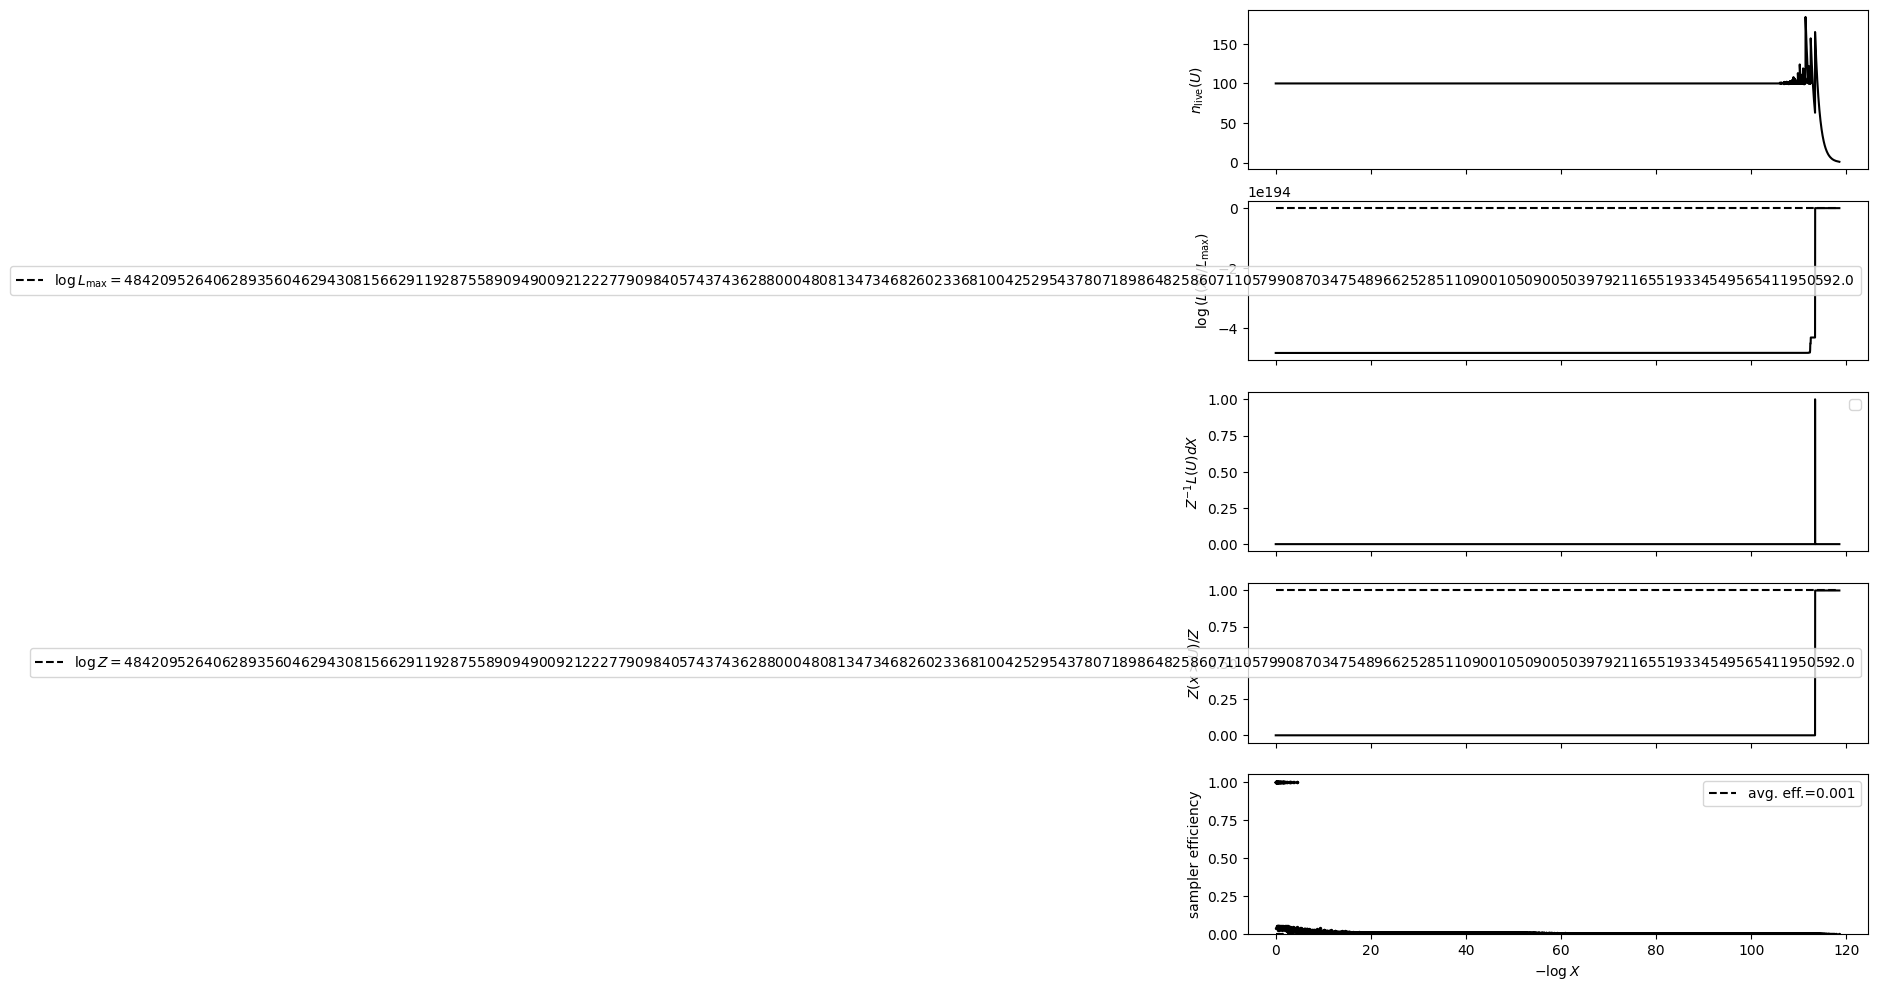

/home/albert/git/jaxns/jaxns/plotting.py:158: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(binsx.min(), binsx.max())


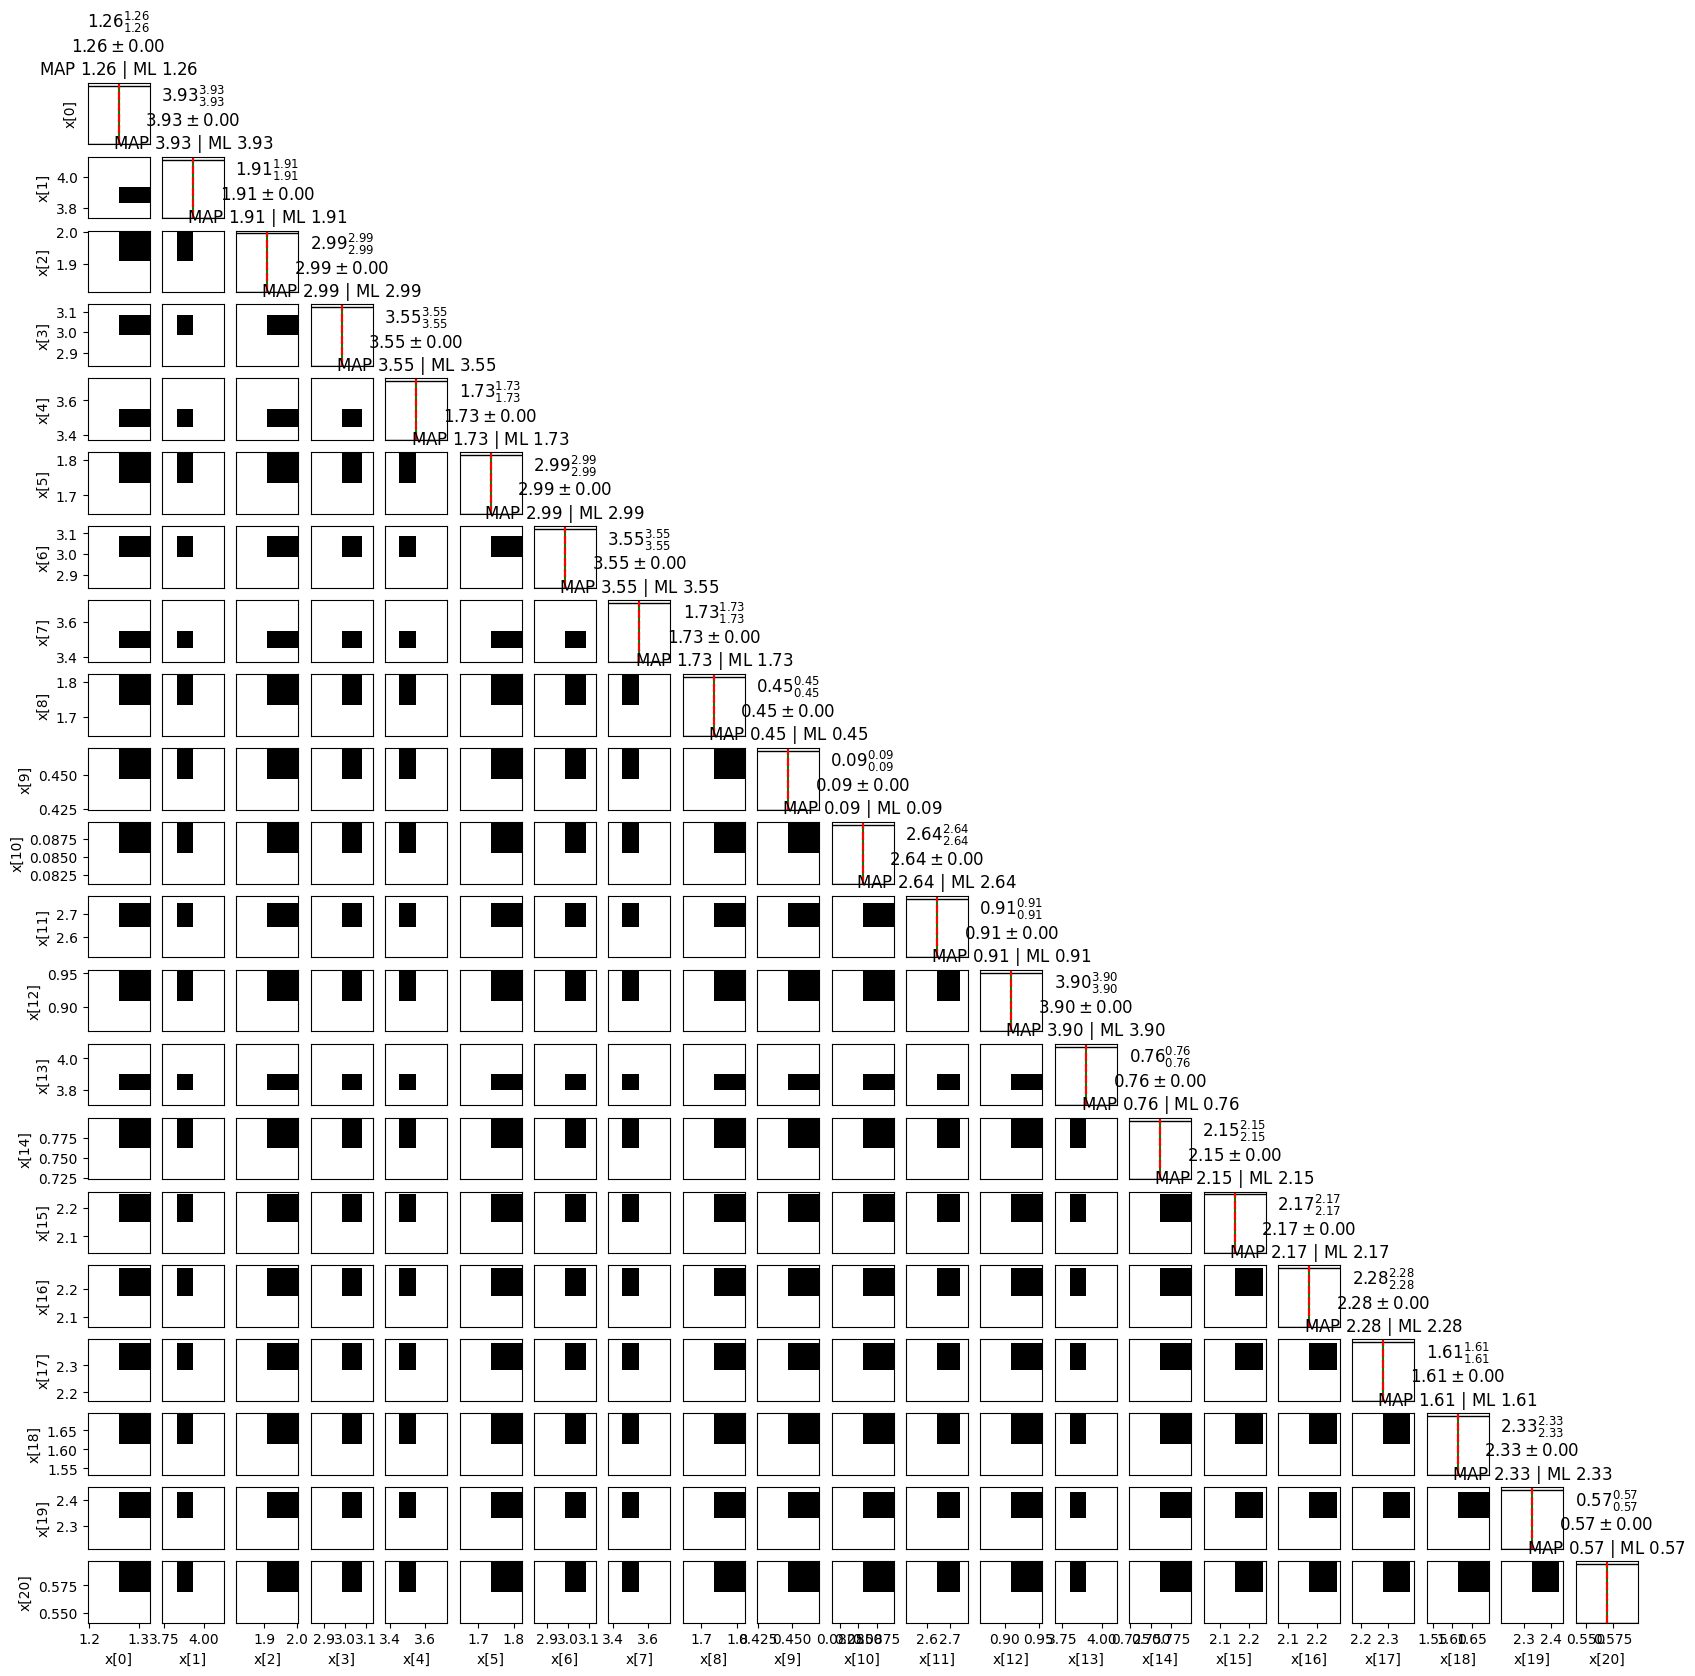

In [6]:
# We plot useful diagnostics and a distribution cornerplot
ns.plot_diagnostics(results)
ns.plot_cornerplot(results)


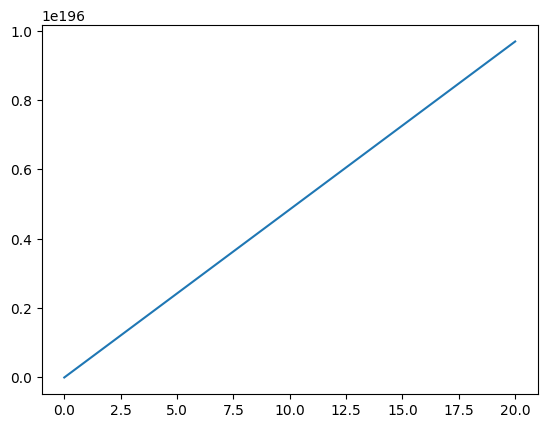

In [7]:
from jax import jit


@jit
def compute_partition(beta):
    # return jnp.sum(results.log_dp_mean * jnp.exp(beta * results.log_L_samples))
    dp_mean = LogSpace(results.log_dp_mean)
    exp_beta_negE = LogSpace(beta * results.log_L_samples)
    return (dp_mean * exp_beta_negE).sum().log_abs_val


x = []
y = []
for beta in jnp.linspace(0, 20, 2000):
    Z_beta = compute_partition(beta)
    x.append(beta)
    y.append(Z_beta)

import pylab as plt

plt.plot(x, y)
plt.show()